In [1]:
# Import Everything

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pandas.tseries.holiday import USFederalHolidayCalendar
import matplotlib.pyplot as plt

In [3]:
# Load EMS Data
df = pd.read_csv("../data/calls_full.csv")
df['CallDateTime'] = pd.to_datetime(df['CallDateTime'])
df = df[(df['CallDateTime'] >= '2017-01-01') & (df['CallDateTime'] < '2025-01-01')]
df['date'] = df['CallDateTime'].dt.date
daily = df.groupby('date').size().reset_index(name='call_volume')
daily['date'] = pd.to_datetime(daily['date'])

daily.head()

,date,call_volume
0,2017-01-01,14
1,2017-01-02,13
2,2017-01-03,15
3,2017-01-04,18
4,2017-01-05,9


In [5]:
# Load Weather Data
weather_df = pd.read_csv("../data/weather_clean.csv")
weather_df['DATE'] = pd.to_datetime(weather_df['DATE'])
weather_df = weather_df[(weather_df['DATE'] >= '2017-01-01') & (weather_df['DATE'] < '2025-01-01')]
weather_df.rename(columns={"DATE": "date"}, inplace=True)

weather_df.head()

,date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS
351,2017-01-01,0.200787,0.0,0.0,51.98,30.92,37.94
352,2017-01-02,0.401575,0.0,0.0,41.00,37.04,37.04
353,2017-01-03,0.700787,0.0,0.0,48.92,37.04,46.94
354,2017-01-04,0.000000,0.0,0.0,53.06,19.04,19.94
355,2017-01-05,0.149606,0.0,0.0,33.98,19.94,23.00


In [6]:
# Merge Call and Weather Data
same_cols = daily.columns.intersection(weather_df.columns).tolist()
daily = pd.merge(daily, weather_df, on=same_cols, how='inner')

In [7]:
daily.head()

,date,call_volume,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS
0,2017-01-01,14,0.200787,0.0,0.0,51.98,30.92,37.94
1,2017-01-02,13,0.401575,0.0,0.0,41.00,37.04,37.04
2,2017-01-03,15,0.700787,0.0,0.0,48.92,37.04,46.94
3,2017-01-04,18,0.000000,0.0,0.0,53.06,19.04,19.94
4,2017-01-05,9,0.149606,0.0,0.0,33.98,19.94,23.00


In [8]:
# Function that generates features for a given dataframe
# ______________________________________
def generate_features(df):
    # Calendar Features
    df['day_of_week'] = df['date'].dt.dayofweek
    df['week_of_year'] = df['date'].dt.isocalendar().week.astype(int)
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day_of_year'] = df['date'].dt.dayofyear

    df['sin_doy'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['cos_doy'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

    df['sin_dow'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_dow'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

    df['sin_woy'] = np.sin(2 * np.pi * df['week_of_year'] / 52.1775)
    df['cos_woy'] = np.cos(2 * np.pi * df['week_of_year'] / 52.1775)

    # Lag features (will be filled during rolling prediction)
    for lag in [1, 2, 3, 7, 14]:
        df[f'lag_{lag}'] = df['call_volume'].shift(lag)

    # Rolling features (will be updated during forecasting)
    df['rolling_3d'] = df['call_volume'].rolling(3).mean()
    df['rolling_7d'] = df['call_volume'].rolling(7).mean()
    df['rolling_30d'] = df['call_volume'].rolling(30).mean()
    df['same_day_last_week'] = df['call_volume'].shift(7)
    df['trend_3d'] = df['rolling_3d'] - df['rolling_7d']

    # Holiday/Weekend flags
    calendar = USFederalHolidayCalendar()
    holidays = calendar.holidays(start=df['date'].min(), end=df['date'].max())
    df['is_holiday'] = df['date'].isin(holidays).astype(int)
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    return df

In [9]:
daily = generate_features(daily)
daily.head()

,date,call_volume,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,day_of_week,week_of_year,...,lag_3,lag_7,lag_14,rolling_3d,rolling_7d,rolling_30d,same_day_last_week,trend_3d,is_holiday,is_weekend
0,2017-01-01,14,0.200787,0.0,0.0,51.98,30.92,37.94,6,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1,2017-01-02,13,0.401575,0.0,0.0,41.00,37.04,37.04,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
2,2017-01-03,15,0.700787,0.0,0.0,48.92,37.04,46.94,1,1,...,NaN,NaN,NaN,14.000000,NaN,NaN,NaN,NaN,0,0
3,2017-01-04,18,0.000000,0.0,0.0,53.06,19.04,19.94,2,1,...,14.0,NaN,NaN,15.333333,NaN,NaN,NaN,NaN,0,0
4,2017-01-05,9,0.149606,0.0,0.0,33.98,19.94,23.00,3,1,...,13.0,NaN,NaN,14.000000,NaN,NaN,NaN,NaN,0,0


In [10]:
# Drop missing values for training only
train_data = daily[daily['date'] < '2023-01-01'].copy()
train_data.dropna(inplace=True)

In [11]:
features = [
    'month', 'year',
    'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14',
    'rolling_3d', 'rolling_7d', 'rolling_30d',
    'same_day_last_week', 'trend_3d',
    'is_holiday', 'is_weekend',
    'sin_doy', 'cos_doy', 'sin_dow', 'cos_dow', 'sin_woy', 'cos_woy',
    'PRCP',	'SNOW',	'SNWD',	'TMAX',	'TMIN',	'TOBS'
]

In [12]:
# Train/Evaluation Data
X_train = train_data[features]
y_train = train_data['call_volume']

# Scale Inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Log-transform targets for training
y_train_log = np.log1p(y_train)

In [13]:
# Build MLP Model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Train with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.1,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.3246 - root_mean_squared_error: 1.4985 - val_loss: 3.3283 - val_root_mean_squared_error: 1.8244
Epoch 2/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4787 - root_mean_squared_error: 0.6914 - val_loss: 1.5047 - val_root_mean_squared_error: 1.2267
Epoch 3/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3755 - root_mean_squared_error: 0.6118 - val_loss: 0.6321 - val_root_mean_squared_error: 0.7950
Epoch 4/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2786 - root_mean_squared_error: 0.5275 - val_loss: 0.2068 - val_root_mean_squared_error: 0.4547
Epoch 5/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2367 - root_mean_squared_error: 0.4864 - val_loss: 0.1099 - val_root_mean_squared_error: 0.3314
Epoch 6/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1937 - root_mean_squared_error: 0.4398 - val_loss: 0.1136 - val_root_mean_squared_error: 0.3371
Epoch 7/300
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss:

In [15]:
# Create a dataframe for the forecast period
# ________________________________________________________________________________________________
last_train_date = train_data['date'].max()
test_start_date = pd.Timestamp('2023-01-01')
test_end_date = pd.Timestamp('2024-12-31')

# Get actual data for 2023-2024 for evaluation
actual_test_data = daily[(daily['date'] >= test_start_date) & (daily['date'] <= test_end_date)].copy()

# Create a new dataframe with all dates in the forecast period
date_range = pd.date_range(start=test_start_date, end=test_end_date)
forecast_df = pd.DataFrame({'date': date_range})
forecast_df['call_volume'] = np.nan  # Will be filled with predictions

In [16]:
# Rolling 14-day forecast
# ________________________________________________________________________________________________
# First, we need to copy the last 14+ days of actual data to initialize our forecast
historical_window = daily[(daily['date'] <= last_train_date) &
                          (daily['date'] > last_train_date - pd.Timedelta(days=30))].copy()

# Combine historical data with forecast dataframe
forecast_with_history = pd.concat([historical_window, forecast_df], ignore_index=True)
forecast_with_history = generate_features(forecast_with_history)

# Initialize columns for storing predictions and forecast types
forecast_with_history['predicted_calls'] = np.nan
forecast_with_history['is_synthetic'] = False  # Flag to track which values are synthetic predictions

# Dictionary to store predictions by date for easy lookup
predictions_by_date = {}

# Extend most recent weather data out (we can do this because weather is autocorrelated)
forecast_with_history[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS']] = \
    forecast_with_history[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS']].fillna(method='ffill')

# Perform rolling forecast
print("Starting 14-day rolling forecast...")
for forecast_date in date_range:
    # Print progress every month
    if forecast_date.day == 1:
        print(f"Forecasting for {forecast_date.strftime('%Y-%m')}")

    # Current forecast window ends 14 days from now
    forecast_window_end = forecast_date + pd.Timedelta(days=13)

    # Get current dataframe slice up to the day before forecast date
    current_df = forecast_with_history[forecast_with_history['date'] < forecast_date].copy()

    # If we have actual data for this date, update it in our forecast
    actual_for_date = actual_test_data[actual_test_data['date'] == forecast_date]
    if not actual_for_date.empty:
        actual_calls = actual_for_date['call_volume'].values[0]
        forecast_with_history.loc[forecast_with_history['date'] == forecast_date, 'call_volume'] = actual_calls
        forecast_with_history.loc[forecast_with_history['date'] == forecast_date, 'is_synthetic'] = False

    # Generate 14-day forecast window
    for days_ahead in range(14):
        target_date = forecast_date + pd.Timedelta(days=days_ahead)

        # Skip if we're beyond the forecast period
        if target_date > test_end_date:
            continue

        # Prepare features for this prediction date
        pred_df = forecast_with_history[forecast_with_history['date'] <= target_date].copy()

        # Generate all features, which will use the latest available call_volume data (actual or synthetic)
        pred_df = generate_features(pred_df)

        # Extract the row for the target date
        target_row = pred_df[pred_df['date'] == target_date]

        # Check if we have all required features
        if target_row[features].isna().any().any():
            # If we're missing data, we can't make a prediction yet
            continue

        # Scale features - using the DataFrame with feature names to avoid warning
        X_pred = target_row[features]
        X_pred_scaled = scaler.transform(X_pred)

        # Make prediction
        pred_log = model.predict(X_pred_scaled, verbose=0).flatten()[0]
        pred_calls = int(np.expm1(pred_log).round())

        # Store prediction in our results
        if target_date == forecast_date:
            # Store today's prediction in the dictionary for evaluation
            predictions_by_date[target_date] = pred_calls

        # Update the forecast dataframe with this prediction if it's synthetic
        # We don't overwrite actual values, only fill in synthetic ones
        if forecast_with_history.loc[forecast_with_history['date'] == target_date, 'call_volume'].isna().any():
            forecast_with_history.loc[forecast_with_history['date'] == target_date, 'call_volume'] = pred_calls
            forecast_with_history.loc[forecast_with_history['date'] == target_date, 'is_synthetic'] = True

        # Store prediction for evaluation
        forecast_with_history.loc[forecast_with_history['date'] == target_date, 'predicted_calls'] = pred_calls

/var/folders/rw/kqv4w2bj5hx2v1ln61zfm4pr0000gn/T/ipykernel_8474/1750178975.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecast_with_history[['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS']].fillna(method='ffill')


Starting 14-day rolling forecast...
Forecasting for 2023-01
Forecasting for 2023-02
Forecasting for 2023-03
Forecasting for 2023-04
Forecasting for 2023-05
Forecasting for 2023-06
Forecasting for 2023-07
Forecasting for 2023-08
Forecasting for 2023-09
Forecasting for 2023-10
Forecasting for 2023-11
Forecasting for 2023-12
Forecasting for 2024-01
Forecasting for 2024-02
Forecasting for 2024-03
Forecasting for 2024-04
Forecasting for 2024-05
Forecasting for 2024-06
Forecasting for 2024-07
Forecasting for 2024-08
Forecasting for 2024-09
Forecasting for 2024-10
Forecasting for 2024-11
Forecasting for 2024-12


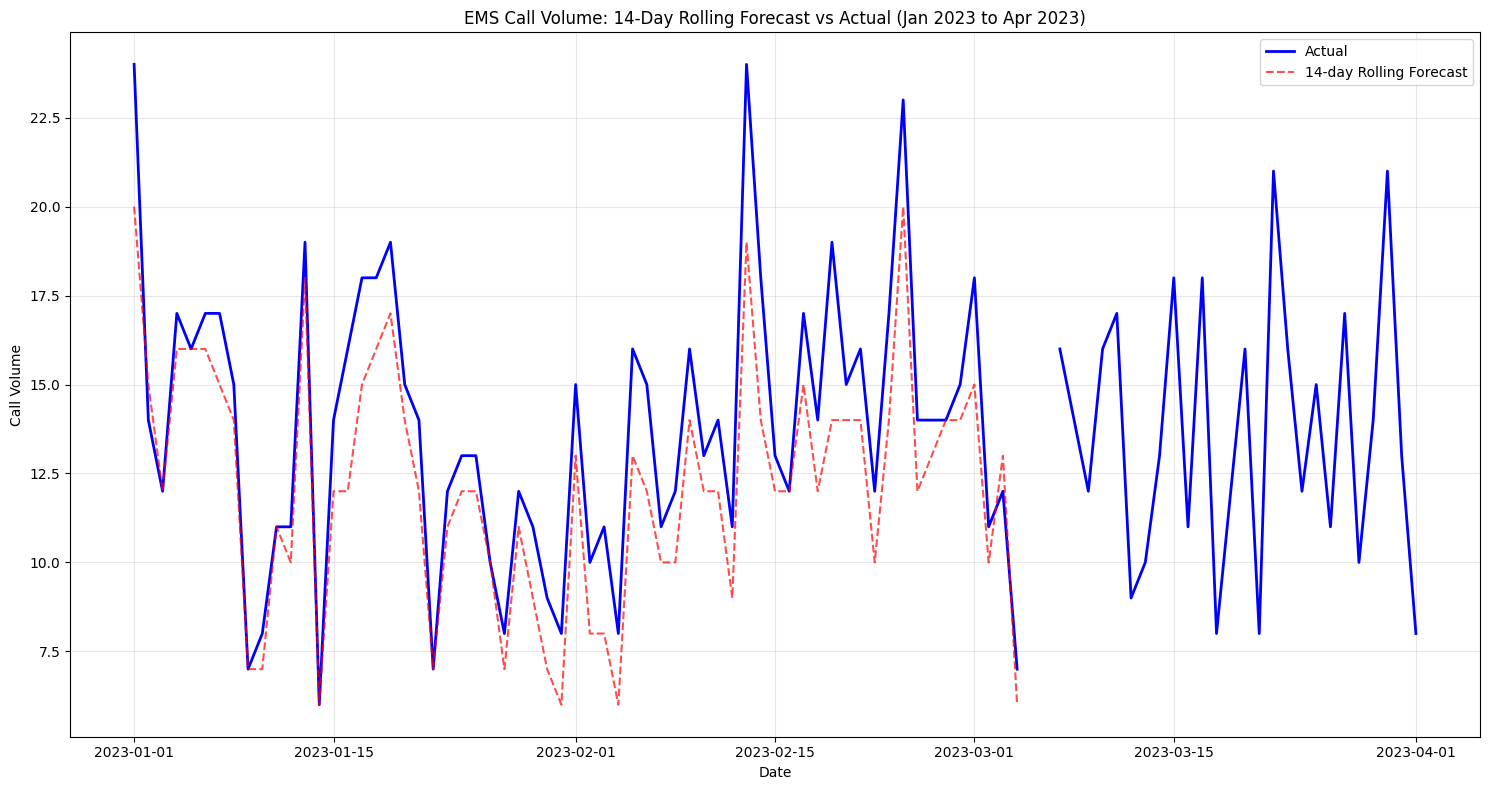

In [17]:
# Plot results
# ________________________________________________________________________________________________
# Filter to actual test period and get necessary columns
plot_df = forecast_with_history[forecast_with_history['date'] >= test_start_date].copy()
plot_df = plot_df[['date', 'call_volume', 'predicted_calls', 'is_synthetic']]

# Merge with actuals for comparison
plot_df = pd.merge(plot_df, actual_test_data[['date', 'call_volume']],
                   on='date', how='left', suffixes=('_pred', '_actual'))

# Create plot
plt.figure(figsize=(15, 8))

# Sample a few months to make the plot clearer
sample_months = 3
sample_start = test_start_date
sample_end = sample_start + pd.Timedelta(days=30*sample_months)

# Filter data for sample period
sample_df = plot_df[(plot_df['date'] >= sample_start) & (plot_df['date'] <= sample_end)]

# Plot actual values
plt.plot(sample_df['date'], sample_df['call_volume_actual'],
         label='Actual', color='blue', linewidth=2)

# Plot predictions
plt.plot(sample_df['date'], sample_df['predicted_calls'],
         label='14-day Rolling Forecast', color='red', linestyle='--', alpha=0.7)

# Formatting
plt.title(f'EMS Call Volume: 14-Day Rolling Forecast vs Actual ({sample_start.strftime("%b %Y")} to {sample_end.strftime("%b %Y")})')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

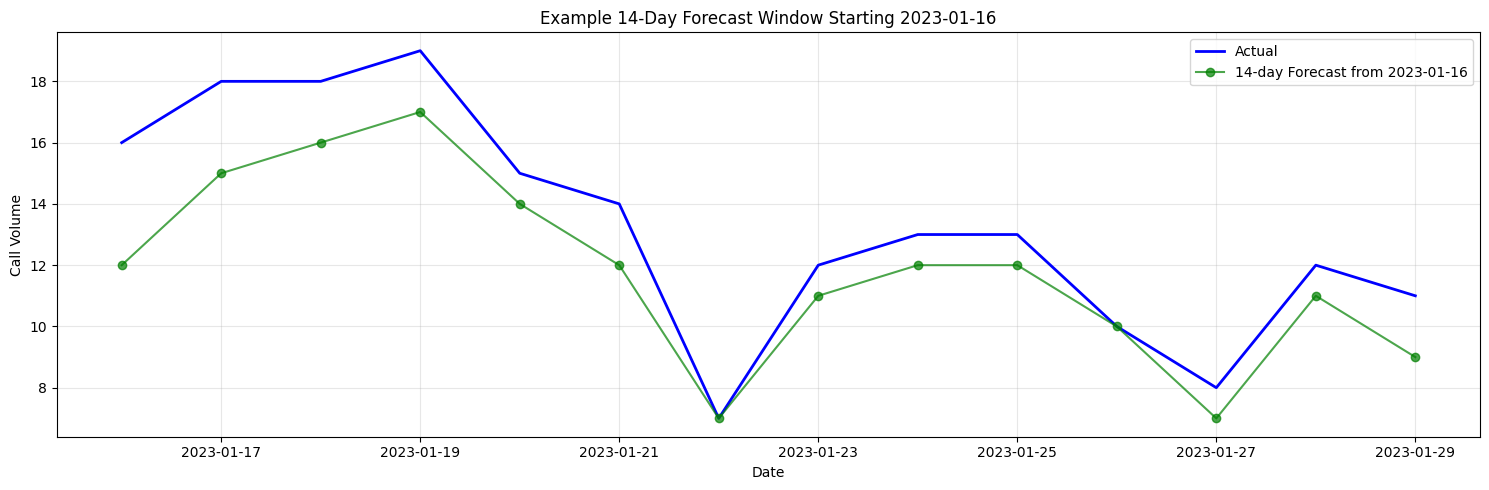

In [18]:
# Create a second plot showing the 14-day forecasts made from a specific day
# ________________________________________________________________________________________________
# Select an example date in the middle of the sample period
forecast_example_date = sample_start + pd.Timedelta(days=15)
forecast_window = pd.date_range(start=forecast_example_date, periods=14)

# Find the forecasts made for this window
forecast_window_df = forecast_with_history[forecast_with_history['date'].isin(forecast_window)].copy()

plt.figure(figsize=(15, 5))
plt.plot(actual_test_data[actual_test_data['date'].isin(forecast_window)]['date'],
         actual_test_data[actual_test_data['date'].isin(forecast_window)]['call_volume'],
         label='Actual', color='blue', linewidth=2)

plt.plot(forecast_window_df['date'], forecast_window_df['predicted_calls'],
         label=f'14-day Forecast from {forecast_example_date.strftime("%Y-%m-%d")}',
         color='green', marker='o', linestyle='-', alpha=0.7)

plt.title(f'Example 14-Day Forecast Window Starting {forecast_example_date.strftime("%Y-%m-%d")}')
plt.xlabel('Date')
plt.ylabel('Call Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()